<img src='https://imagenes.20minutos.es/files/article_amp/uploads/2015/09/24/192629.jpg' alt='Van Gogh' width="400">

**<h1> Clasificación automática de pinturas </h1>**


Fuente: https://www.kaggle.com/ikarus777/best-artworks-of-all-time

> Se pretender realizar la clasificación de algunos de los artistas más importantes mendiante k-means.

---

# 1. Entendimiento del negocio

## 1.1 Objetivos

- Comprobar que existe y se detecta un agrupamiento en las obras de artes, ya sea por artista, país, estilo.

- Obtener un agrupamiento para comparar la similitud entre obras artísticas.

Esto podría ser de interés para corroborar que los artistas tienen cierta concordancia en su obra, además, que pueden tener influencias por el país, estilos, entre otros.

## 1.2 Metas

- Encontrar que existe una concordancia de estilo en los artistas.

- Descubrir la relación intrínseca que tienen las obras.

## 1.3 Planeación



1.   Adquisición de los datos en: https://www.kaggle.com/ikarus777/best-artworks-of-all-time
2. Filtrar los datos de interés de esta fuente.
3. Realizar un análisis exploratorio.
4. Limpiar los datasets.
5. Transformar las imágenes según las necesidades.
6. Aplicar un modelo de reducción de dimensionalidad y clustering para obtener agrupamientos óptimos.
7. Resultados.



# 2. Entendimiento de los datos

## 2.0 Módulos

Se instalan, cargan y configuran los módulos a utilizar en el proyecto.

In [ ]:
!pip install -U plotly

In [3]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import plotly
import PIL
import glob
import re
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.metrics import make_scorer
from sklearn.metrics import silhouette_score
from sklearn import preprocessing

In [4]:
pd.options.plotting.backend = 'plotly'

## 2.1 Montar Drive

Se carga el drive para poder tener una mejor gestión de los datos.

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## 2.2 Cargar datos

Se define la dirección donde se guardarán y cargarán archivos.

In [6]:
path = '/content/drive/My Drive/Colab Notebooks/diplomado_ds/ml/data'

In [7]:
path_art = f'{path}/art'

Se carga archivo que contiene la información de los artistas, la cual fue extraída de Kaggle y almacenado en el drive.

In [8]:
df_info = pd.read_csv(f'{path}/artists.csv')  # información de los artistas

## 2.3 Exploración

Se imprimen algunas filas del dataframe:

In [9]:
df_info.head(3)

,id,name,years,genre,nationality,bio,wikipedia,paintings
0,0,Amedeo Modigliani,1884 - 1920,Expressionism,Italian,Amedeo Clemente Modigliani (Italian pronunciat...,http://en.wikipedia.org/wiki/Amedeo_Modigliani,193
1,1,Vasiliy Kandinskiy,1866 - 1944,"Expressionism,Abstractionism",Russian,Wassily Wassilyevich Kandinsky (Russian: Васи́...,http://en.wikipedia.org/wiki/Wassily_Kandinsky,88
2,2,Diego Rivera,1886 - 1957,"Social Realism,Muralism",Mexican,Diego María de la Concepción Juan Nepomuceno E...,http://en.wikipedia.org/wiki/Diego_Rivera,70


Se tiene que el dataset contiene 50 artistas en total:

In [10]:
df_info.shape

(50, 8)

Se observa el tipo de dato de cada columna:

In [11]:
df_info.dtypes

id              int64
name           object
years          object
genre          object
nationality    object
bio            object
wikipedia      object
paintings       int64
dtype: object

### 2.3.1 No. de Pinturas por artista

En la siguiente figura se observa que en general el número de pinturas por artistas parece estar acotado entre 0 y 200 imágenes en el dataset, esto se puede confirmar con un boxplot, también hay dos artistas que tienen una gran cantidad de obras, estos son Vincent van Gogh y Edgar Degas.

In [12]:
df_info.plot(kind='bar',
             x = 'name',
             y = 'paintings',
             labels={
                 'name': 'Artista',
                 'paintings': 'No. Pinturas'
                 },
             title='Número de pinturas')

Para confirmar lo anterior se realiza un boxplot, y como se sospechaba, la mayoría de obras por artista se encuentran entre 24 y 336, los artistas que tienen mayores obras que estas son considerados como datos atípicos.

In [13]:
df_info.paintings.plot(kind='box',
                       labels={
                           'value': 'No. Pinturas'
                       },
                       title='Número de pinturas (Boxplot)')

Se obtiene que la mediana es 123, y el número mínimo de pinturas es 24. Por otro lado, para hacer que los datos estén balanceados se toman los artistas que tengan mínimo 81 pinturas, y se hace muestreo a los que tengan más de estas.

In [14]:
df_info.paintings.describe()

count     50.000000
mean     168.920000
std      157.451105
min       24.000000
25%       81.000000
50%      123.000000
75%      191.750000
max      877.000000
Name: paintings, dtype: float64

### 2.3.2 Nacionalidades de los artistas





En la siguiente figura se observa que la mayoría de artistas del dataset son europeos.

In [15]:
df_info.nationality.value_counts().plot(kind='bar', 
                                        labels={
                                            'value': 'Frecuencia',
                                            'index': 'Nacionalidad'
                                            },
                                        title='Nacionalidad de artistas')

Por otro lado, se ven el número de artistas que tienen al menos 81 pinturas en el dataset, y se toma la decisión de tomar las naciones que tienen al menos 4 artistas que cumplan la condición anterior, y se hace muestreo a las que tengan más de estas.

In [16]:
min_paint = 81

(df_info.nationality
 .where(df_info.paintings >= min_paint)
 .value_counts()
 .plot(kind='bar', 
       labels={
           'value': 'Frecuencia',
           'index': 'Nacionalidad'
           },
       title='Nacionalidad de artistas (min 81 pinturas)'))

### 2.3.3 Corrientes artísticas

En la siguiente figura se observa el número de corrientes artísticas presentes en el dataset.

In [17]:
df_info.genre.value_counts().plot(kind='bar',
                                  labels={
                                      'value': 'No. Artistas',
                                      'index': 'Corriente artística'
                                      },
                                  title='Número de Corrientes artísticas')

En la siguiente gráfica se observan las corrientes artísticas de los pintores que tienen al menos 81 pinturas en el dataset y son de: Francia, Italia, España, Países bajos o Rusia. Se obtiene que en la mayoría de casos hay un exponente por cada estilo o combinación de estilos.

In [18]:
nationality_filter = ['French', 'Italian', 'Spanish', 'Dutch', 'Russian']
min_paint = 81

(df_info.genre
 .where(
     (df_info.paintings >= min_paint) 
     & 
     (df_info.nationality.isin(nationality_filter)))
 .value_counts()
 .plot(kind='bar', 
       labels={
           'value': 'No. Artistas',
           'index': 'Corriente artística'
           },
       title='Número de Corrientes artísticas'))

# 3. Preparación de los datos

## 3.1 Balancear datos por país y número de artistas

Dada la exploración anterior se procede a realizar los filtros mencionados:

1. Artistas con mínimo 81 pinturas en el dataset.
2. Artistas que sean de: Francia, Italia, España, Países bajos o Rusia. (Máximo 4 por país.)

**Nota:** Se elimina a Diego Velazquez porque no están todas las pinturas.



In [19]:
min_paint = 81
nationality_filter = ['French', 'Italian', 'Spanish', 'Dutch', 'Russian']
min_nationality = 4
seed = 75

df_info_filtered = (df_info[
                            (df_info.nationality.isin(nationality_filter)) 
                            & 
                            (df_info.paintings >= min_paint)
                            &
                            (df_info.name != 'Diego Velazquez')
                            ]
                    .groupby('nationality', group_keys=False)
                    .apply(lambda x: x.sample(4, random_state=seed))
                    )

Luego se obtienen 20 artistas, los cuales son:

In [20]:
df_info_filtered.shape

(20, 8)

In [21]:
df_info_filtered.name

31                    Rembrandt
10             Hieronymus Bosch
43                Piet Mondrian
8              Vincent van Gogh
33    Henri de Toulouse-Lautrec
28                Henri Matisse
35             Camille Pissarro
15        Pierre-Auguste Renoir
24            Sandro Botticelli
32                       Titian
23            Giotto di Bondone
26            Leonardo da Vinci
11             Kazimir Malevich
7                 Andrei Rublev
12               Mikhail Vrubel
1            Vasiliy Kandinskiy
16               Francisco Goya
13                Pablo Picasso
44                    Joan Miro
5                 Salvador Dali
Name: name, dtype: object

Se confirma que haya balanceo respecto al país.

In [22]:
df_info_filtered.nationality.value_counts()

Dutch      4
Russian    4
Spanish    4
Italian    4
French     4
Name: nationality, dtype: int64

Además, se rectifica que el número mínimo de pinturas sea 81 por artista.

In [23]:
df_info_filtered.paintings.describe()

count     20.000000
mean     209.500000
std      184.169116
min       81.000000
25%      101.250000
50%      141.000000
75%      256.750000
max      877.000000
Name: paintings, dtype: float64

## 3.2 Obtener directorios de imágenes

Se reemplazan los espacios de los nombres de artistas por: "_"

In [24]:
df_info_filtered.name = (df_info_filtered
                         .name
                         .apply(lambda x: x.replace(' ', '_')))

In [25]:
df_info_filtered.name.head()

31                    Rembrandt
10             Hieronymus_Bosch
43                Piet_Mondrian
8              Vincent_van_Gogh
33    Henri_de_Toulouse-Lautrec
Name: name, dtype: object

Se obtienen los directorios de las imágenes de los artistas:

In [26]:
all_path = glob.glob(f'{path}/art/*.*')

In [27]:
all_path[:5]

['/content/drive/My Drive/Colab Notebooks/diplomado_ds/ml/data/art/Titian_35.jpg',
 '/content/drive/My Drive/Colab Notebooks/diplomado_ds/ml/data/art/Titian_49.jpg',
 '/content/drive/My Drive/Colab Notebooks/diplomado_ds/ml/data/art/Titian_85.jpg',
 '/content/drive/My Drive/Colab Notebooks/diplomado_ds/ml/data/art/Vincent_van_Gogh_110.jpg',
 '/content/drive/My Drive/Colab Notebooks/diplomado_ds/ml/data/art/Vincent_van_Gogh_1.jpg']

## 3.3 Balancear datos por número de pinturas

Se extraen los directorios de los artistas requeridos.

In [28]:
artists = df_info_filtered.name.to_list()

In [29]:
regex_art = '|'.join(artists)

In [30]:
path_art = [path for path in all_path if re.search(regex_art, path)]
path_art.sort()

In [31]:
path_art[:5]

['/content/drive/My Drive/Colab Notebooks/diplomado_ds/ml/data/art/Andrei_Rublev_1.jpg',
 '/content/drive/My Drive/Colab Notebooks/diplomado_ds/ml/data/art/Andrei_Rublev_10.jpg',
 '/content/drive/My Drive/Colab Notebooks/diplomado_ds/ml/data/art/Andrei_Rublev_11.jpg',
 '/content/drive/My Drive/Colab Notebooks/diplomado_ds/ml/data/art/Andrei_Rublev_12.jpg',
 '/content/drive/My Drive/Colab Notebooks/diplomado_ds/ml/data/art/Andrei_Rublev_13.jpg']

Se extraen nombres de archivos.

In [32]:
regex_file = '|'.join([artist + '.*jpg' for artist in artists])

In [33]:
file_name = [re.findall(regex_file, artist)[0] for artist in path_art]

In [34]:
file_name[:5]

['Andrei_Rublev_1.jpg',
 'Andrei_Rublev_10.jpg',
 'Andrei_Rublev_11.jpg',
 'Andrei_Rublev_12.jpg',
 'Andrei_Rublev_13.jpg']

Se obtiene la cantidad de archivos por artista.

In [35]:
paint_art = [re.findall(regex_art, artist)[0] for artist in path_art]

In [36]:
paint_path_art_df = pd.DataFrame(list(zip(path_art, paint_art, file_name)), columns=['path', 'artist', 'file_name'])

In [39]:
paint_path_art_df.artist.value_counts()

Vincent_van_Gogh             877
Pablo_Picasso                439
Pierre-Auguste_Renoir        336
Francisco_Goya               291
Rembrandt                    262
Titian                       255
Henri_Matisse                186
Mikhail_Vrubel               171
Sandro_Botticelli            164
Leonardo_da_Vinci            143
Salvador_Dali                139
Hieronymus_Bosch             137
Kazimir_Malevich             126
Giotto_di_Bondone            119
Joan_Miro                    102
Andrei_Rublev                 99
Camille_Pissarro              91
Vasiliy_Kandinskiy            88
Piet_Mondrian                 84
Henri_de_Toulouse-Lautrec     81
Name: artist, dtype: int64

Se verifica que haya el mismo número de artistas.

In [40]:
paint_path_art_df.artist.value_counts().shape

(20,)

Se hace muestreo por artista.

In [41]:
min_pain = 81
seed = 34

sample_art_df = (paint_path_art_df
                 .groupby('artist', group_keys=False)
                 .apply(lambda x: x.sample(min_pain, random_state=seed))
                 )

Se comprueba el número de pinturas por artista.

In [42]:
sample_art_df.artist.value_counts()

Pablo_Picasso                81
Hieronymus_Bosch             81
Francisco_Goya               81
Mikhail_Vrubel               81
Titian                       81
Joan_Miro                    81
Giotto_di_Bondone            81
Piet_Mondrian                81
Salvador_Dali                81
Henri_de_Toulouse-Lautrec    81
Sandro_Botticelli            81
Henri_Matisse                81
Andrei_Rublev                81
Vincent_van_Gogh             81
Camille_Pissarro             81
Pierre-Auguste_Renoir        81
Kazimir_Malevich             81
Vasiliy_Kandinskiy           81
Rembrandt                    81
Leonardo_da_Vinci            81
Name: artist, dtype: int64

## 3.4 Visualización de pintura

In [43]:
artist_vis = 'Andrei_Rublev'
index = 0

img = PIL.Image.open(sample_art_df
                     .path
                     .where(sample_art_df.artist == artist_vis)
                     [index])

img = np.array(img)

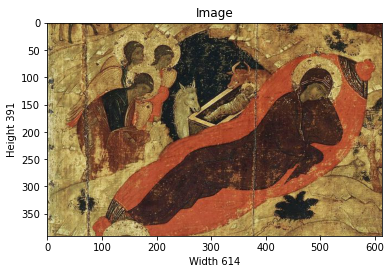

In [44]:
plt.title('Image')
plt.ylabel('Height {}'.format(img.shape[0]))
plt.xlabel('Width {}'.format(img.shape[1]))
plt.imshow(img);

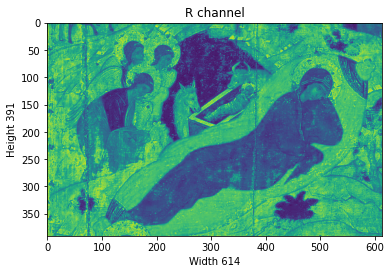

In [45]:
plt.title('R channel')
plt.ylabel('Height {}'.format(img.shape[0]))
plt.xlabel('Width {}'.format(img.shape[1]))
plt.imshow(img[ : , : , 0]);

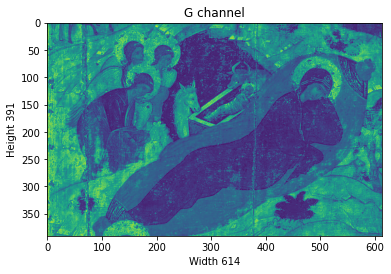

In [46]:
plt.title('G channel')
plt.ylabel('Height {}'.format(img.shape[0]))
plt.xlabel('Width {}'.format(img.shape[1]))

plt.imshow(img[ : , : , 1]);

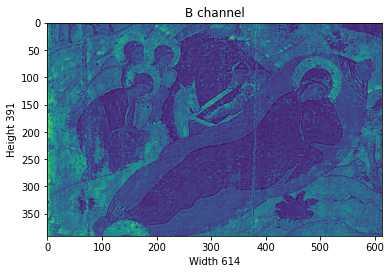

In [47]:
plt.title('B channel')
plt.ylabel('Height {}'.format(img.shape[0]))
plt.xlabel('Width {}'.format(img.shape[1]))
plt.imshow(img[ : , : , 2]);

# 4. Modelamiento

Se decide utiliza el algoritmo de k-means para comprobar si se detecta un agrupamiento según el artista, el país, o la corriente artística, esto podría ser señal de una concordancia en la obra de cada uno de los pintores.

## 4.1 Cargar y separa imágenes en train y test

Se crea función que aplica una reducción de la dimensión a las imágenes para mejorar el entrenamiento. Esta reducción se realiza por medio de la función Image.resize() la cuál tiene como método por defecto la interpolación bicúbica, que es más suave que otros métodos como "nearest neighbour" o "interpolación bilineal" y que para cada pixel considera otros 16 pixeles para ajustar su valor.

In [48]:
def load_data(img_path: pd.Series, width: int = 50, height: int = 50) -> np.ndarray:
    len_vec = width * height * 3
    
    img_path_list = img_path.to_list()
    len_path_list = len(img_path_list)

    img_list_all = []
    for i in range(len_path_list):
        img = PIL.Image.open(img_path_list[i])
        img = img.convert('RGB').resize((width, height))
        img = np.asarray(img) / 255.0
        img = img.reshape((len_vec, 1))
        img_list_all.append(img)

        print( i / len_path_list)
        
    img_array = np.array(img_list_all)

    return img_array.reshape(-1, len_vec)

Se separan los directorios de las imágenes en entrenamiento y test.

In [49]:
X = sample_art_df.path

le = preprocessing.LabelEncoder()
y = le.fit_transform(sample_art_df.artist).reshape(-1, 1)

seed = 64

X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size = 0.1,
                                                    random_state=seed,
                                                    stratify=y)

In [50]:
X_train.shape

(1458,)

In [51]:
X_test.shape

(162,)

Se cargan las imágenes.

In [52]:
X_train_img = load_data(X_train)

0.0
0.0006858710562414266
0.0013717421124828531
0.00205761316872428
0.0027434842249657062
0.003429355281207133
0.00411522633744856
0.004801097393689987
0.0054869684499314125
0.006172839506172839
0.006858710562414266
0.0075445816186556925
0.00823045267489712
0.008916323731138546
0.009602194787379973
0.0102880658436214
0.010973936899862825
0.011659807956104253
0.012345679012345678
0.013031550068587106
0.013717421124828532
0.01440329218106996
0.015089163237311385
0.01577503429355281
0.01646090534979424
0.017146776406035666
0.01783264746227709
0.018518518518518517
0.019204389574759947
0.019890260631001373
0.0205761316872428
0.021262002743484224
0.02194787379972565
0.02263374485596708
0.023319615912208505
0.02400548696844993
0.024691358024691357
0.025377229080932786
0.02606310013717421
0.026748971193415638
0.027434842249657063
0.028120713305898493
0.02880658436213992
0.029492455418381344
0.03017832647462277
0.030864197530864196
0.03155006858710562
0.03223593964334705
0.03292181069958848
0.0

Se checa el tamaño del dataset.

In [53]:
X_train_img.shape

(1458, 7500)

Se visualiza imagen.

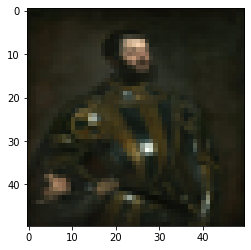

In [57]:
img = X_train_img[10]
shape = (50, 50, 3)

plt.imshow(img.reshape(shape));

## 4.2 Pipeline PCA -> KMeans

Se realiza una reducción de la dimensionalidad con PCA y en la segunda etapa se entrena un modelo de clasificación no supervisado KMeans.

In [58]:
def train_pipe(X_train: np.ndarray, y_train: list , parameters: dict, k: int) -> any:
    
    estimators = [
                  ('pca', PCA()),
                  ('kmeans', KMeans())
                  ]
    pipe_art = Pipeline(estimators)
    metric_clu = make_scorer(silhouette_score)
    grid = GridSearchCV(pipe_art, parameters, cv=k, scoring=metric_clu)
    grid_search = grid.fit(X_train, y_train)

    return grid_search

Se buscan los mejores hiperparámetros.

In [59]:
parameters = {
    'pca__n_components': [2, 5, 10, 25],
    'kmeans__n_clusters': [2, 5, 10, 15, 20]
}

In [60]:
gsearch = train_pipe(X_train_img, y_train, parameters, k=10)

In [62]:
print(f"Silhouette_score (val): {gsearch.best_score_}")
print("Mejor configuración de parámetros:")

best_parameters = gsearch.best_params_
for param in sorted(parameters.keys()):
    print(f"\t{param}: {best_parameters[param]}")

Silhouette_score (val): 0.009535183426115734
Mejor configuración de parámetros:
	kmeans__n_clusters: 2
	pca__n_components: 2


Se obtienen los clúster.

In [63]:
y_train_clustering = gsearch.predict(X_train_img)

In [64]:
np.unique(y_train_clustering)

array([0, 1], dtype=int32)

Se evalúa el método del codo.

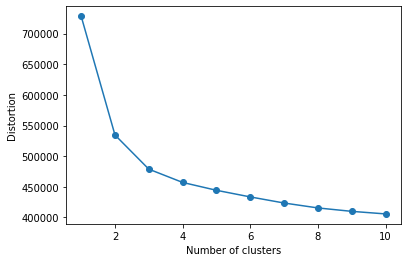

In [65]:
distortions = []
for i in range(1, 11):
    km = KMeans(
        n_clusters=i, init='random',
        n_init=10, max_iter=300,
        tol=1e-04, random_state=0
    )
    km.fit(X_train_img)
    distortions.append(km.inertia_)

plt.plot(range(1, 11), distortions, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Distortion')
plt.show()

## 4.3 EDA Clúster train

Se evalúan los clúster.

In [68]:
def show_batch(image_batch: np.ndarray, label_batch: np.ndarray) -> None:
    plt.figure(figsize=(10,10))
    for n in range(32):
        ax = plt.subplot(8, 4, n + 1)
        plt.subplots_adjust(hspace = .5)
        image = image_batch[n]
        image = image.reshape((50, 50, 3))
        plt.imshow(image)
        plt.title(label_batch[n])
        plt.axis('off')

    return None

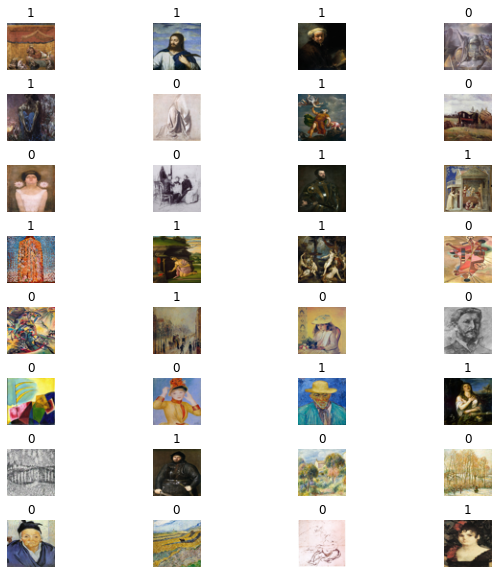

In [67]:
show_batch(X_train_img, y_train_clustering)

In [80]:
X_train_eda = pd.DataFrame(list(zip(X_train, y_train_clustering)), columns=['path', 'cluster'])

df_data_train = pd.merge(X_train_eda, paint_path_art_df, 'left', ['path'])
df_data_train = df_data_train.rename(columns={'artist': 'name'})
df_data_train = pd.merge(df_data_train, df_info_filtered, 'left', ['name'])
df_data_train.head(2)

,path,cluster,name,file_name,id,years,genre,nationality,bio,wikipedia,paintings
0,/content/drive/My Drive/Colab Notebooks/diplom...,1,Giotto_di_Bondone,Giotto_di_Bondone_32.jpg,23,1266 - 1337,Proto Renaissance,Italian,Giotto di Bondone (Italian pronunciation: [ˈdʒ...,http://en.wikipedia.org/wiki/Giotto_di_Bondone,119
1,/content/drive/My Drive/Colab Notebooks/diplom...,1,Titian,Titian_170.jpg,32,1488 - 1576,"High Renaissance,Mannerism",Italian,Tiziano Vecelli or Tiziano Vecellio (pronounce...,http://en.wikipedia.org/wiki/Titian,255


In [108]:
def grap_cluster(df: pd.DataFrame, var: str) -> any:
    fig = (df
           .groupby([var, 'cluster'])
           .count()
           .reset_index()
           .plot(kind='bar',
                 x=var,
                 y='id',
                 color='cluster',
                 labels={'id': 'Frecuencia'},
                 title=f'Número de pinturas ({var})'
                 )
           )
    return fig

In [109]:
grap_cluster(df_data_train, 'name')

In [110]:
grap_cluster(df_data_train, 'nationality')

In [111]:
grap_cluster(df_data_train, 'genre')

# 5. Evaluación

## 5.1 Datos de test

In [112]:
X_test_img = load_data(X_test)

0.0
0.006172839506172839
0.012345679012345678
0.018518518518518517
0.024691358024691357
0.030864197530864196
0.037037037037037035
0.043209876543209874
0.04938271604938271
0.05555555555555555
0.06172839506172839
0.06790123456790123
0.07407407407407407
0.08024691358024691
0.08641975308641975
0.09259259259259259
0.09876543209876543
0.10493827160493827
0.1111111111111111
0.11728395061728394
0.12345679012345678
0.12962962962962962
0.13580246913580246
0.1419753086419753
0.14814814814814814
0.15432098765432098
0.16049382716049382
0.16666666666666666
0.1728395061728395
0.17901234567901234
0.18518518518518517
0.19135802469135801
0.19753086419753085
0.2037037037037037
0.20987654320987653
0.21604938271604937
0.2222222222222222
0.22839506172839505
0.2345679012345679
0.24074074074074073
0.24691358024691357
0.25308641975308643
0.25925925925925924
0.2654320987654321
0.2716049382716049
0.2777777777777778
0.2839506172839506
0.29012345679012347
0.2962962962962963
0.30246913580246915
0.30864197530864196


In [113]:
print(f'Silhouette_score (test): {gsearch.score(X_test_img, y_test)}')

Silhouette_score (test): 0.00139183170557137


Se obtiene la predicción:

In [114]:
y_test_clustering = gsearch.predict(X_test_img)

## 5.2 EDA Clúster test

Se evalúan los clúster.

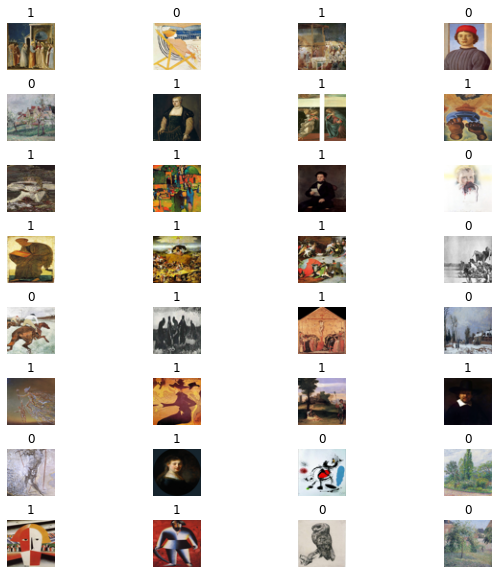

In [115]:
show_batch(X_test_img, y_test_clustering)

In [116]:
X_test_eda = pd.DataFrame(list(zip(X_test, y_test_clustering)), columns=['path', 'cluster'])

df_data_test = pd.merge(X_test_eda, paint_path_art_df, 'left', ['path'])
df_data_test = df_data_test.rename(columns={'artist': 'name'})
df_data_test = pd.merge(df_data_test, df_info_filtered, 'left', ['name'])
df_data_test.head(2)

,path,cluster,name,file_name,id,years,genre,nationality,bio,wikipedia,paintings
0,/content/drive/My Drive/Colab Notebooks/diplom...,1,Giotto_di_Bondone,Giotto_di_Bondone_46.jpg,23,1266 - 1337,Proto Renaissance,Italian,Giotto di Bondone (Italian pronunciation: [ˈdʒ...,http://en.wikipedia.org/wiki/Giotto_di_Bondone,119
1,/content/drive/My Drive/Colab Notebooks/diplom...,0,Henri_de_Toulouse-Lautrec,Henri_de_Toulouse-Lautrec_9.jpg,33,1864 – 1901,Post-Impressionism,French,Henri Marie Raymond de Toulouse-Lautrec-Monfa ...,https://en.wikipedia.org/wiki/Henri_de_Toulous...,81


In [117]:
grap_cluster(df_data_test, 'name')

In [118]:
grap_cluster(df_data_test, 'nationality')

In [119]:
grap_cluster(df_data_test, 'genre')

**Al parecer hay un factor que agrupa de forma discriminante los grupos, puede que utilizar 3 bandas para cada imagen pueda ser contraproducente, sin embargo, se observa que Italia parece tener un papel protagónico para la agrupación de estas obras de arte, queda como trabajo futuro implementar otros artistas y transformar las imágenes a blanco y negro.**